In [1]:
# train_models.py
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump
import tensorflow as tf


In [2]:
# ------------------------------------------------------------------
# 1. Carga de datos
# ------------------------------------------------------------------
DATA_DIR = Path('.')          # ajusta si lo necesitas
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df   = pd.read_csv(DATA_DIR / 'val.csv')
test_df  = pd.read_csv(DATA_DIR / 'test.csv')
levels_df  = pd.read_csv(DATA_DIR / 'plagiarism_levels.csv')
target_col  = 'result'


In [3]:
# ------------------------------------------------------------------
# Cargar cadenas de MArkov
# ------------------------------------------------------------------
SPACE = " "
def str_to_vec(s: str) -> np.ndarray:
    """Convierte la cadena '0.123 0.0 …' en vector float32."""
    return np.fromstring(s, sep=SPACE, dtype=np.float32)

def build_feature_matrix(df: pd.DataFrame) -> np.ndarray:
    """
    Output:  [simhash, astsimilarity,  markov1(flat) , markov2(flat) , |diff| ]
              └─2 cols──┘          └────────── 3 × L  ───────────────┘
    """
    base   = df[["simhash", "astsimilarity"]].values.astype("float32")

    m1 = np.vstack(df["markov1"].apply(str_to_vec))
    m2 = np.vstack(df["markov2"].apply(str_to_vec))
    diff = np.abs(m1 - m2)

    return np.hstack([base, m1, m2, diff])

vlen   = len(str_to_vec(train_df["markov1"].iloc[0]))
dim_v  = int(np.sqrt(vlen))
print(f"Vocab Markov detectado: {dim_v} nodos  =>  {vlen} números por matriz")


# %%

Vocab Markov detectado: 52 nodos  =>  2704 números por matriz


In [4]:

feature_cols = ["simhash", "astsimilarity"]

X_train = build_feature_matrix(train_df)
X_val   = build_feature_matrix(val_df)
X_test  = build_feature_matrix(test_df)
X_levels = build_feature_matrix(levels_df)

y_train = train_df[target_col].astype("int8").values
y_val   = val_df  [target_col].astype("int8").values
y_test  = test_df [target_col].astype("int8").values
y_levels = levels_df[target_col].astype("int8").values
# ------------------------------------------------------------------
# 2. Pre-procesamiento: escalamos numéricos
# ------------------------------------------------------------------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)
X_levels_sc = scaler.transform(X_levels)



In [5]:

# ------------------------------------------------------------------
# 3. Modelo 0 — Baseline con TensorFlow
# ------------------------------------------------------------------
def build_tf_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

tf_model = build_tf_model(X_train_sc.shape[1])
tf_model.fit(X_train_sc, y_train,
             validation_data=(X_val_sc, y_val),
             epochs=50, batch_size=256, verbose=0,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

print('\n🟢 TensorFlow — Test metrics')
tf_metrics = tf_model.evaluate(X_test_sc, y_test, verbose=0)
for name, val in zip(tf_model.metrics_names, tf_metrics):
    print(f'{name}: {val:.4f}')
tf_model.save('tf_baseline.keras')


# %%

C:\Users\casas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



🟢 TensorFlow — Test metrics
loss: 0.5002
compile_metrics: 0.7681


In [6]:

# ------------------------------------------------------------------
# 4. Modelo 1 — Regresión logística
# ------------------------------------------------------------------
logreg = LogisticRegression(max_iter=2000, n_jobs=-1)
logreg.fit(X_train_sc, y_train)
print('\n🟢 LogReg — Val accuracy:',
      accuracy_score(y_val, logreg.predict(X_val_sc)))
dump(('scaler', scaler, 'logreg', logreg), 'logreg.joblib')


# %%



🟢 LogReg — Val accuracy: 0.7157190635451505


['logreg.joblib']

In [7]:
# ------------------------------------------------------------------
# 5. Modelo 2 — Random Forest
# ------------------------------------------------------------------
rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42)
rf.fit(X_train, y_train)                  # RF no necesita escalado
print('\n🟢 RandomForest — Val accuracy:',
      accuracy_score(y_val, rf.predict(X_val)))
dump(rf, 'rf.joblib')


# %%


🟢 RandomForest — Val accuracy: 0.7090301003344481


['rf.joblib']

In [8]:
# ------------------------------------------------------------------
# 6. Modelo 3 — XGBoost
# ------------------------------------------------------------------
xgb_clf = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42)

xgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

print('\n🟢 XGBoost — Val accuracy:',
      accuracy_score(y_val, (xgb_clf.predict(X_val) > 0.5)))
xgb_clf.save_model('xgb.json')




🟢 XGBoost — Val accuracy: 0.7792642140468228


In [9]:

# 7. Comparación final en TEST
# ------------------------------------------------------------------
def evaluate(name, y_true, y_pred, y_prob):
    print(f'🔸 {name}: acc={accuracy_score(y_true, y_pred):.4f}',
          f'f1={f1_score(y_true, y_pred):.4f}',
          f'auc={roc_auc_score(y_true, y_prob):.4f}')

print('\n📊  Métricas finales en TEST:')
evaluate('LogReg',
         y_test,
         logreg.predict(X_test_sc),
         logreg.predict_proba(X_test_sc)[:,1])

evaluate('RandomForest',
         y_test,
         rf.predict(X_test),
         rf.predict_proba(X_test)[:,1])

evaluate("XGBoost",
         y_test,
         (xgb_clf.predict(X_test) > 0.5),
         xgb_clf.predict_proba(X_test)[:,1])

tf_pred_prob = tf_model.predict(X_test_sc).ravel()
tf_pred_bin  = (tf_pred_prob > 0.5).astype(int)
evaluate("TensorFlow", y_test, tf_pred_bin, tf_pred_prob)


# %%


📊  Métricas finales en TEST:
🔸 LogReg: acc=0.7651 f1=0.7174 auc=0.8759
🔸 RandomForest: acc=0.8313 f1=0.8133 auc=0.9091
🔸 XGBoost: acc=0.8434 f1=0.8344 auc=0.9297
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
🔸 TensorFlow: acc=0.7681 f1=0.7298 auc=0.8594


In [10]:
# ---------------------------------------------------------------
#  MATRICES DE CONFUSIÓN (set de TEST)
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.rcParams["figure.figsize"] = (5.5, 5.5)

# --- predicciones ------------------------------------------------
y_pred_logreg = logreg.predict(X_test_sc)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = (xgb_clf.predict(X_test) > 0.5).astype(int)
tf_prob = tf_model.predict(X_test_sc).ravel()
y_pred_tf = (tf_prob > 0.5).astype(int)

# --- modelos + preds en un dict ---------------------------------
models = {
    "LogReg" : y_pred_logreg,
    "RandomForest" : y_pred_rf,
    "XGBoost" : y_pred_xgb,
    "TensorFlow" : y_pred_tf
}

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


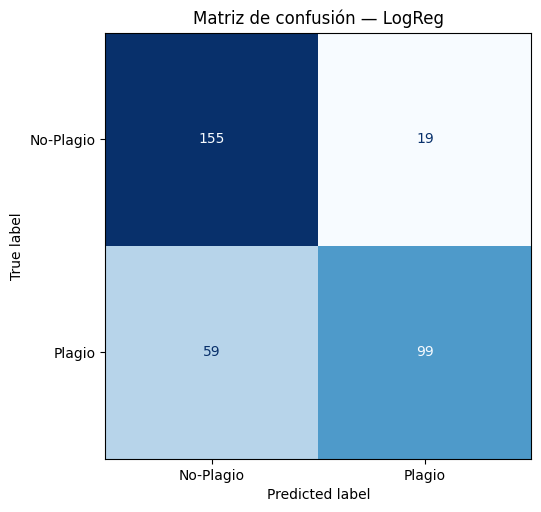


Reporte de clasificación — LogReg
              precision    recall  f1-score   support

   No-Plagio       0.72      0.89      0.80       174
      Plagio       0.84      0.63      0.72       158

    accuracy                           0.77       332
   macro avg       0.78      0.76      0.76       332
weighted avg       0.78      0.77      0.76       332



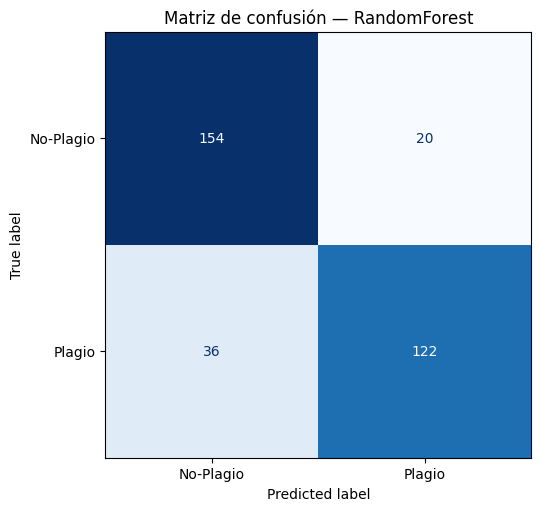


Reporte de clasificación — RandomForest
              precision    recall  f1-score   support

   No-Plagio       0.81      0.89      0.85       174
      Plagio       0.86      0.77      0.81       158

    accuracy                           0.83       332
   macro avg       0.83      0.83      0.83       332
weighted avg       0.83      0.83      0.83       332



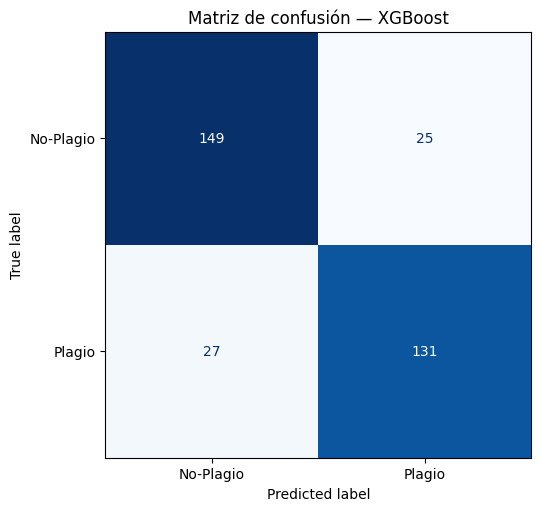


Reporte de clasificación — XGBoost
              precision    recall  f1-score   support

   No-Plagio       0.85      0.86      0.85       174
      Plagio       0.84      0.83      0.83       158

    accuracy                           0.84       332
   macro avg       0.84      0.84      0.84       332
weighted avg       0.84      0.84      0.84       332



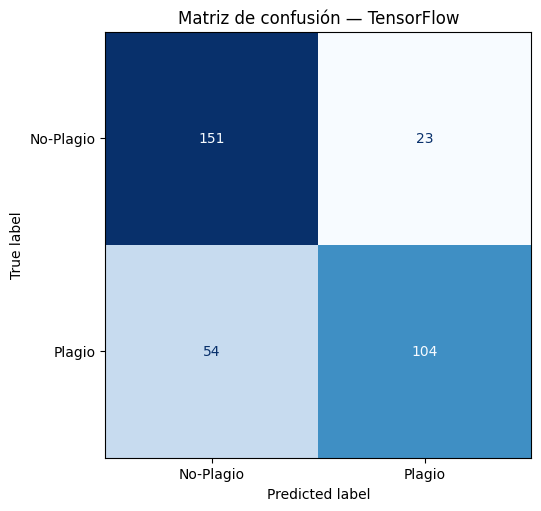


Reporte de clasificación — TensorFlow
              precision    recall  f1-score   support

   No-Plagio       0.74      0.87      0.80       174
      Plagio       0.82      0.66      0.73       158

    accuracy                           0.77       332
   macro avg       0.78      0.76      0.76       332
weighted avg       0.78      0.77      0.76       332



In [11]:

# --- dibuja e imprime -------------------------------------------
for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No-Plagio", "Plagio"])
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    ax.set_title(f"Matriz de confusión — {name}")
    plt.tight_layout()
    plt.show()

    print(f"\nReporte de clasificación — {name}")
    print(classification_report(y_test, y_pred,
                                target_names=["No-Plagio", "Plagio"]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


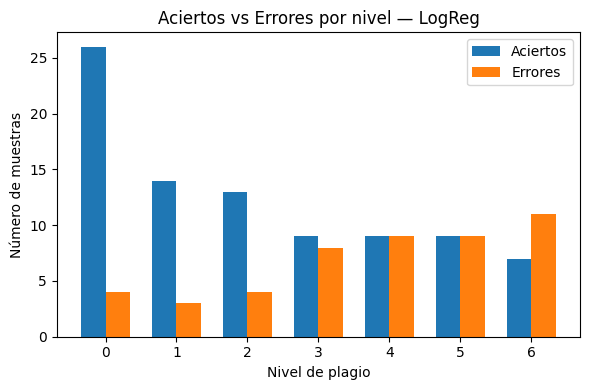

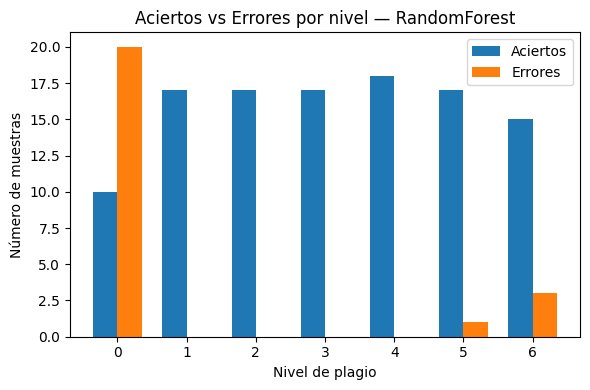

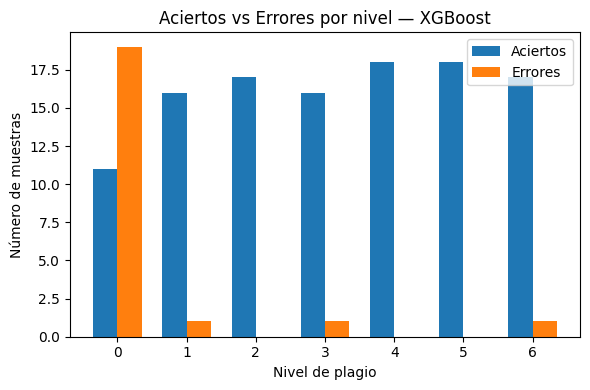

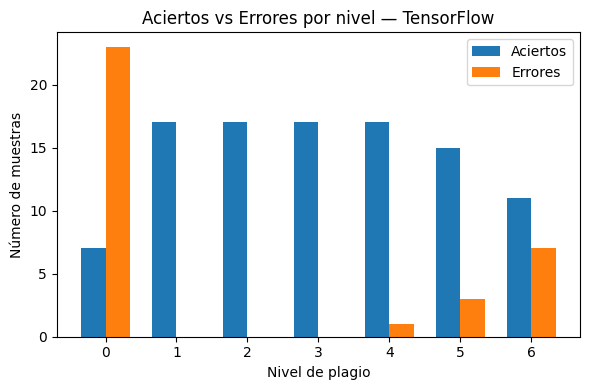

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Predicciones sobre el conjunto de niveles
y_pred_logreg_lvl    = logreg.predict(X_levels_sc)
y_pred_rf_lvl        = rf.predict(X_levels)
y_pred_xgb_lvl       = (xgb_clf.predict(X_levels) > 0.5).astype(int)
tf_prob_lvl          = tf_model.predict(X_levels_sc).ravel()
y_pred_tf_lvl        = (tf_prob_lvl > 0.5).astype(int)

models_levels = {
    "LogReg"       : y_pred_logreg_lvl,
    "RandomForest" : y_pred_rf_lvl,
    "XGBoost"      : y_pred_xgb_lvl,
    "TensorFlow"   : y_pred_tf_lvl
}

# Etiquetas reales y niveles de plagio
actual_levels = levels_df["plagiarism_level"].values
true_labels   = levels_df[target_col].astype("int8").values

levels = np.unique(actual_levels)
levels.sort()

# Graficar aciertos vs errores por nivel para cada modelo 
for name, y_pred in models_levels.items():
    correct   = []
    incorrect = []
    for lvl in levels:
        mask = (actual_levels == lvl)
        corr = (y_pred[mask] == true_labels[mask]).sum()
        total = mask.sum()
        correct.append(corr)
        incorrect.append(total - corr)

    x = np.arange(len(levels))
    width = 0.35

    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, correct,   width, label="Aciertos")
    plt.bar(x + width/2, incorrect, width, label="Errores")
    plt.xticks(x, levels)
    plt.xlabel("Nivel de plagio")
    plt.ylabel("Número de muestras")
    plt.title(f"Aciertos vs Errores por nivel — {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()
